# Inverse Engineering 1: Optical Filter Recovery

In [13]:
## Import libraries, set random seed for reproducibility, and define device and parameters
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# include parent dir
import sys
sys.path.append('..')
from camflow import OpticalFilter, ADC, Demosaic
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cpu")
# Parameters
H, W = 800, 800
C = 31  # spectral channels

(1) Init + Training

In [14]:
# Inverse Engineering 1: Optical Filter Recovery
# Ground-truth filter: Gaussian-shaped already defined in OpticalFilter init, but let's define our own GT here
start_wl, end_wl = 400, 700
wavelengths = torch.linspace(start_wl, end_wl, C)
gt_mean, gt_std = 550.0, 100.0
gt_filter = torch.exp(-0.5 * ((wavelengths - gt_mean) / gt_std)**2)
gt_filter = gt_filter / gt_filter.max()
num_iters = 200
# Generate random scene spectral radiance [H,W,C]
scene_radiance = torch.rand(H, W, C) # U(0,1)

# Apply GT filter
filtered_scene = scene_radiance * gt_filter  # element-wise
filtered_scene = filtered_scene.unsqueeze(0) # [1,H,W,C]

# We will start from a U(0,1) random OpticalFilter and try to recover gt_filter
optical_model = OpticalFilter(num_channels=C).to(device)
# Overwrite initial filter with random init
with torch.no_grad():
    optical_model.filter.data = torch.rand(C)

opt = optim.Adam(optical_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_iters)

init_filter = optical_model.filter.detach().clone()
# In[3]:
# Train optical filter recovery
losses_optical = []
for i in range(num_iters):
    opt.zero_grad()
    pred = optical_model(scene_radiance.unsqueeze(0))
    loss = ((pred - filtered_scene)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_optical.append(loss.item())
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}")

Iteration 50, Loss: 0.000095
Iteration 100, Loss: 0.000000
Iteration 150, Loss: 0.000000
Iteration 200, Loss: 0.000000


(2) Plot & Save output

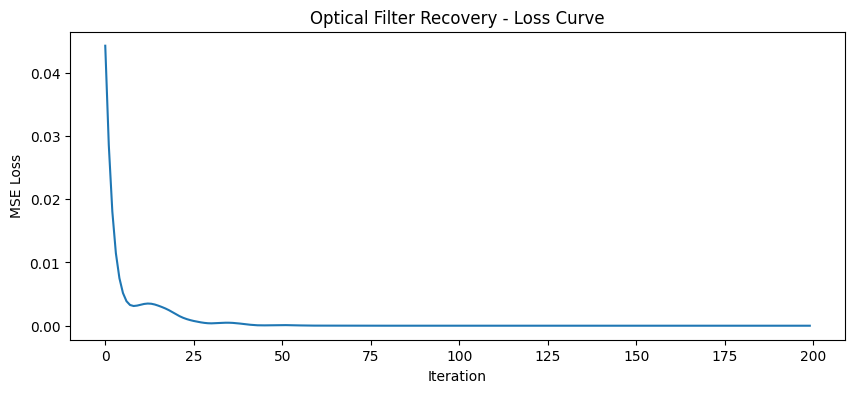

<Figure size 640x480 with 0 Axes>

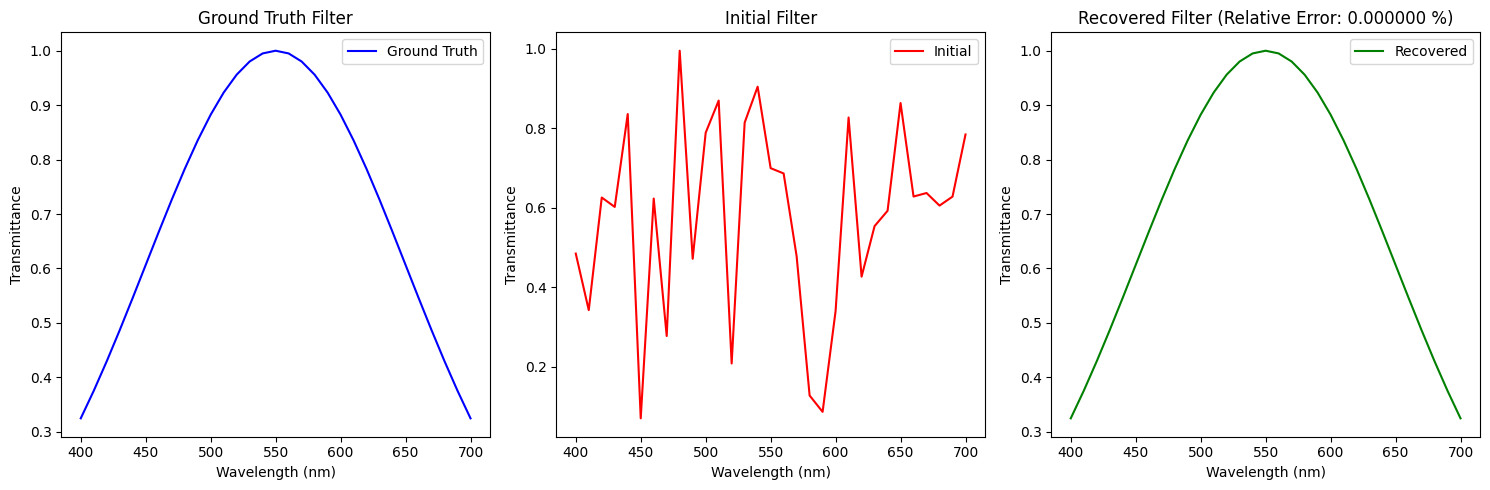

In [16]:
# mkdir dir called result if not exist
if not os.path.exists('results'):
    os.makedirs('results')

# Plot results for Optical Filter
plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
plt.plot(losses_optical)
plt.title("Optical Filter Recovery - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

# save loss curve
plt.savefig('results/optical_filter_loss_curve.png')
plt.show()
# clear plot
plt.clf()

# Plot results for Optical Filter
plt.figure(figsize=(15, 5))

# Ground Truth Filter
plt.subplot(1, 3, 1)
plt.plot(wavelengths, gt_filter.detach().numpy(), label='Ground Truth', color='blue')
plt.title("Ground Truth Filter")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmittance")
plt.legend()

# Recovered Filter
rel_error = torch.sum(gt_filter - optical_model.filter) / torch.sum(gt_filter)
plt.subplot(1, 3, 3)
plt.plot(wavelengths, optical_model.filter.detach().numpy(), label='Recovered', color='green')
plt.title(f"Recovered Filter (Relative Error: {rel_error:.6f} %)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmittance")
plt.legend()

# Initial Filter
plt.subplot(1, 3, 2)
plt.plot(wavelengths, init_filter.numpy(), label='Initial', color='red')
plt.title("Initial Filter")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmittance")
plt.legend()

plt.tight_layout()
# save filter plot
plt.savefig('results/optical_filter_opt.png')
plt.show()

# save plot
